#### ViT Model for Classification of All Defects (including nones)
ViT Model from Google [paper](https://arxiv.org/abs/2010.11929)
using Keras implementation from faustomorales [GitHub](https://github.com/faustomorales/vit-keras)

Data preprocessing:
- Resized to 224x224 with n=2 morphological thinning applied
- Using all data - no undersampling or augmenting

ViT model:
- Size = Base (12 layers, D = 768)
- Patch size = 16
- Using included top with softmax activation

In [ ]:
#### RUN VIT REQUIREMENTS NOTEBOOK FIRST ####
# need to install required packages to environment before running the model

In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks
from vit_keras import vit, utils

import os
import time
import numpy as np
import pandas as pd
import cv2
from skimage.morphology import skeletonize, thin

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [2]:
tf.__version__

'2.4.0'

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [5]:
# specify variables
path = 'processed_data/vit'
filename = 'WM-clean-vit224thin'

result_path = 'results_vit'
model_id = 'vit-b16'
data_id = '224thin'
note = '' # -optional

In [6]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        18G       221G        32M       305M        15G
-/+ buffers/cache:       3.2G       236G
Swap:           0B         0B         0B


In [7]:
# load dataset
from io import BytesIO
start = time.time()

data_key = f'{path}/{filename}.npz'
data_obj = my_bucket.Object(data_key).get()['Body'].read()
data = np.load(BytesIO(data_obj), allow_pickle=True)

print('Wall time: {:.3f} seconds'.format(time.time() - start))
data.files

Wall time: 1.809 seconds


['ids', 'labels', 'dataset', 'thinmap']

In [8]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        18G       221G        32M       305M        15G
-/+ buffers/cache:       3.3G       236G
Swap:           0B         0B         0B


#### Data set-up

In [9]:
# prepare inputs
start = time.time()

x_train = data['thinmap'][data['dataset']=='train']
x_val = data['thinmap'][data['dataset']=='dev']
x_test = data['thinmap'][data['dataset']=='test']

print('Wall time: {:.3f} seconds'.format(time.time() - start))
print(f'Train: {x_train.shape}')
print(f'Dev: {x_val.shape}')
print(f'Test: {x_test.shape}')

Wall time: 243.537 seconds
Train: (121065, 224, 224, 3)
Dev: (25942, 224, 224, 3)
Test: (25943, 224, 224, 3)


In [10]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = data['labels'][data['dataset']=='train']
y_val = data['labels'][data['dataset']=='dev']
y_test = data['labels'][data['dataset']=='test']

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: type = int, min = 0, max = 8
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

Wall time: 0.04 seconds
<class 'numpy.uint8'>
0 0 0
8 8 8


In [11]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        45G       194G        32M       1.8G        15G
-/+ buffers/cache:        28G       211G
Swap:           0B         0B         0B


#### Model

In [12]:
# fine-tune using pre-trained vit model
image_size = 224
model = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=9
)

model.summary()

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Model: "vit-b16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 14, 14, 768)       590592    
_________________________________________________________________
reshape (Reshape)            (None, 196, 768)          0         
_________________________________________________________________
class_token (ClassToken)     (None, 197, 768)          768       
_________________________________________________________________
Transformer/posembed_input ( (None, 197, 768)          151296    
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 197, 768), (None, 7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 197, 768), (None, 7087

In [13]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [14]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        45G       194G        32M       1.8G        15G
-/+ buffers/cache:        28G       211G
Swap:           0B         0B         0B


In [15]:
# run model
start = time.time()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=16, epochs=10)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Epoch 1/10
7567/7567 [==============================] - 1826s 239ms/step - loss: 0.3170 - accuracy: 0.9126 - val_loss: 0.2704 - val_accuracy: 0.9230
Epoch 2/10
7567/7567 [==============================] - 1805s 239ms/step - loss: 0.2347 - accuracy: 0.9316 - val_loss: 0.2523 - val_accuracy: 0.9237
Epoch 3/10
7567/7567 [==============================] - 1805s 239ms/step - loss: 0.2414 - accuracy: 0.9294 - val_loss: 0.2492 - val_accuracy: 0.9291
Epoch 4/10
7567/7567 [==============================] - 1809s 239ms/step - loss: 0.2383 - accuracy: 0.9306 - val_loss: 0.2319 - val_accuracy: 0.9333
Epoch 5/10
7567/7567 [==============================] - 1802s 238ms/step - loss: 0.2553 - accuracy: 0.9253 - val_loss: 0.2486 - val_accuracy: 0.9275
Epoch 6/10
7567/7567 [==============================] - 1807s 239ms/step - loss: 0.2465 - accuracy: 0.9260 - val_loss: 0.2307 - val_accuracy: 0.9310
Epoch 7/10
7567/7567 [==============================] - 1805s 239ms/step - loss: 0.2305 - accuracy: 0.9305

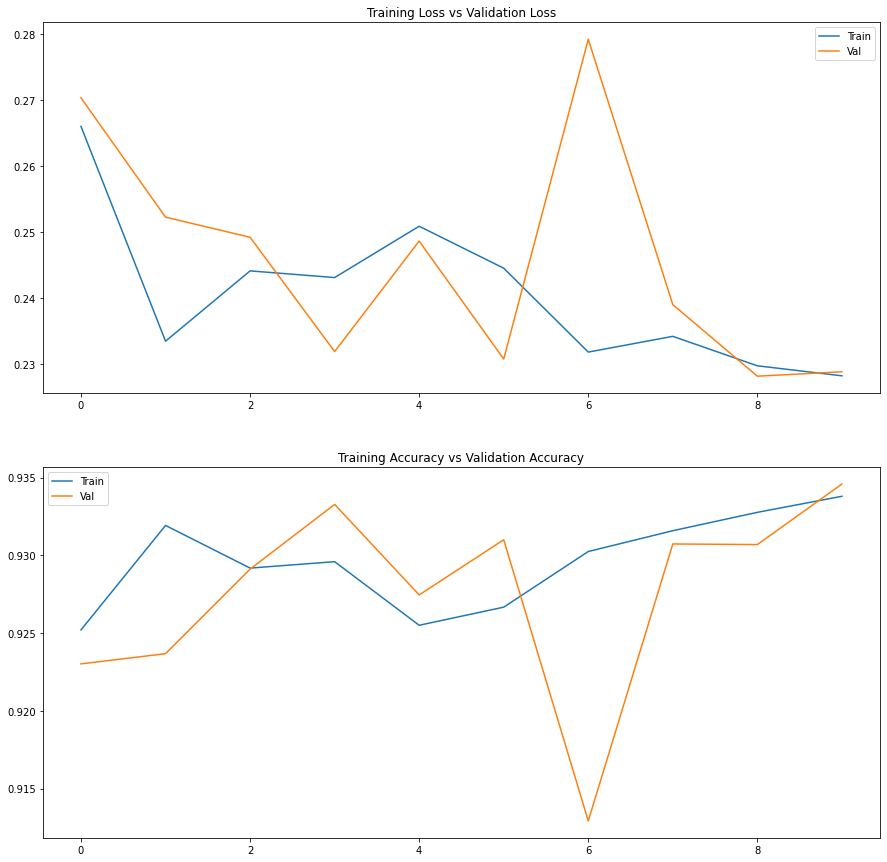

In [16]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [17]:
# save model to S3
# s3_save_keras_model(model, f'{model_id}-{data_id}{note}')
model.save(f'{model_id}-{data_id}{note}.h5')

In [18]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

811/811 [==============================] - 114s 141ms/step - loss: 0.2291 - accuracy: 0.9344
Wall time: 116.99 seconds
[0.2291395664215088, 0.9343946576118469]


In [19]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_max = np.argmax(y_pred, axis=1).astype(np.uint8)
predictions = [y_max, y_pred]
print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 117.51 seconds


In [20]:
# save predictions to local instance
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

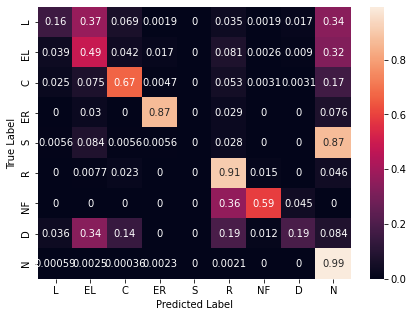

In [21]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=True)

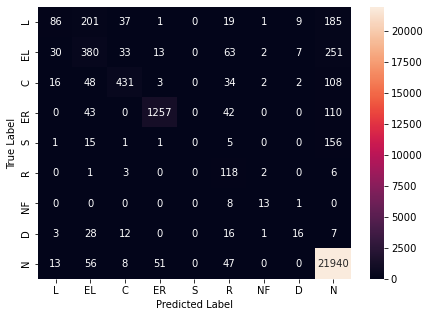

In [22]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=False)